# Exploratory Data Analysis (EDA)

The primary objective of EDA is to gain a thorough understanding of the dataset’s structure and characteristics in order to design an effective preprocessing pipeline for subsequent model training.

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import random
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.stats import levene, kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

## 0. Dataset Overview

In [2]:
DATA_DIR = "../data/images"

# One-time filesystem scan
class_names = sorted(
    [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
)

class_to_files = {
    cls: [
        os.path.join(DATA_DIR, cls, f)
        for f in os.listdir(os.path.join(DATA_DIR, cls))
        if f.lower().endswith(".jpg")
    ]
    for cls in class_names
}

# Flat index (handy for later loops)
files_df = pd.DataFrame(
    [{"class": cls, "path": p} for cls, paths in class_to_files.items() for p in paths]
)

num_classes = len(class_names)
total_images = len(files_df)

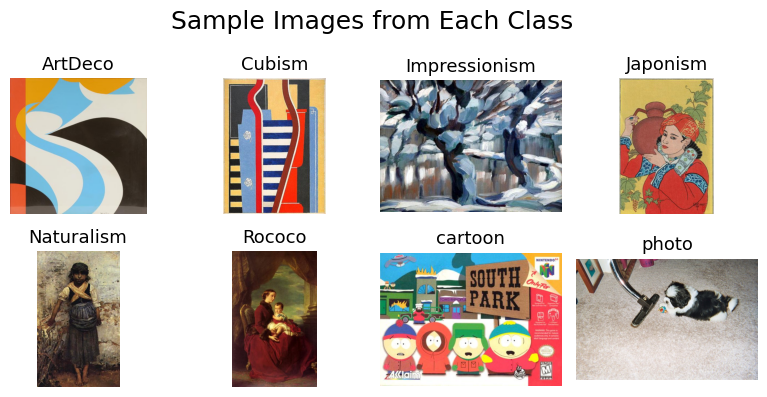

Classes: 8 | Total images: 1422


In [3]:
seed = 618
random.seed(seed)

cols = 4
rows = -(-num_classes // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    ax = axes[i]
    ax.axis("off")
    image_files = class_to_files[cls]

    if not image_files:
        ax.set_title(f"{cls}\n(No Images)", fontsize=12, color="red")
        continue

    image_path = random.choice(image_files)
    with Image.open(image_path) as img:
        ax.imshow(img)
    ax.set_title(cls, fontsize=13)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Sample Images from Each Class", fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

print(f"Classes: {num_classes} | Total images: {total_images}")


## 1. Dataset Distribution
Evaluating the class distribution helps determine whether the dataset is balanced or dominated by certain classes.

In [4]:
distribution_df = (
    files_df.groupby("class").size().reset_index(name="Count")
    .sort_values("Count", ascending=False)
    .rename(columns={"class": "Class Name"})
)

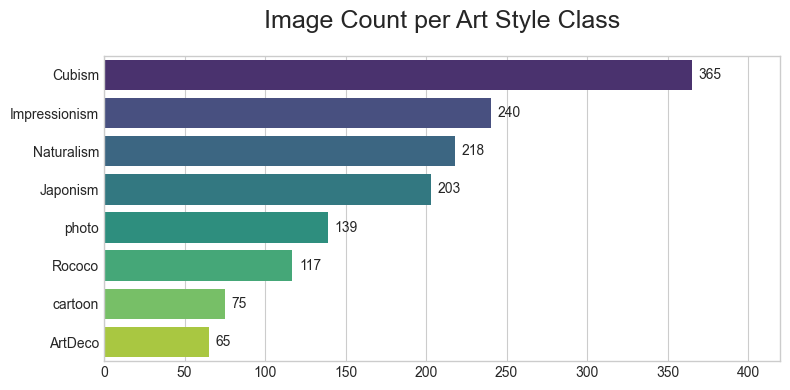

In [5]:
# Visualize data distribution
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    x='Count',
    y='Class Name',
    data=distribution_df,
    palette='viridis',
    orient='h',
    hue='Class Name',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=5)

plt.title('Image Count per Art Style Class', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, distribution_df['Count'].max() * 1.15)
plt.tight_layout()
plt.show()

The dataset shows a clear **class imbalance**. Cubism contains over five times as many images as smaller classes like ArtDeco or cartoon.

❗❗❗ Such uneven distribution could cause the model to become biased toward dominant styles if appropriate balancing techniques are not applied.

## 2. Image Dimension Analysis

In [6]:
# Combined loop for efficiency
records = []
for _, row in files_df.iterrows():
    with Image.open(row["path"]) as img:
        # Get dimensions and mode
        w, h = img.size
        mode = img.mode
        # Get average color intensities
        arr = np.array(img.convert("RGB"))
        R, G, B = arr[..., 0].mean(), arr[..., 1].mean(), arr[..., 2].mean()
        
    records.append({
        "class": row["class"], 
        "width": w, 
        "height": h, 
        "mode": mode,
        "R": R, 
        "G": G, 
        "B": B
    })

# A single DataFrame now holds all properties
image_properties_df = pd.DataFrame(records)

In [7]:
print("\n=== Image Dimensions Summary ===")
print(image_properties_df.describe())


=== Image Dimensions Summary ===
             width       height            R            G            B
count  1422.000000  1422.000000  1422.000000  1422.000000  1422.000000
mean    433.488045   424.085091   134.302760   123.412961   107.786125
std      79.794164    79.679216    37.278698    37.640415    39.847707
min      80.000000    82.000000    10.164688     9.567803     8.193157
25%     371.250000   367.250000   109.613950    98.237711    77.305065
50%     490.000000   422.000000   132.312614   122.018038   105.809638
75%     500.000000   500.000000   158.389213   147.834967   135.095207
max     500.000000   500.000000   244.686154   244.686154   244.686154


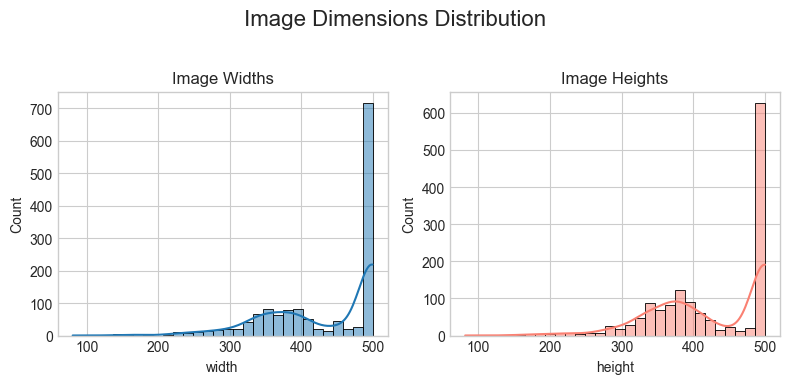

In [8]:
plt.figure(figsize=(8, 4))
plt.suptitle('Image Dimensions Distribution', fontsize=16)

plt.subplot(1, 2, 1)
sns.histplot(image_properties_df['width'], kde=True, bins=30)
plt.title('Image Widths')

plt.subplot(1, 2, 2)
sns.histplot(image_properties_df['height'], kde=True, bins=30, color='salmon')
plt.title('Image Heights')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Most images in the dataset are around 500×500 pixels, as seen from the peaks in both plots.

The vast majority exceed 128 pixels in both width and height, meaning that only a small number will require upscaling when resized to 128×128. This is advantageous, as downscaling generally preserves visual quality, whereas upscaling can introduce blurring and artificial artifacts.

## 3. Image Colors
### 3.1. Descriptive Statistics
The entire dataset consists of images in the RGB color mode.

In [9]:
image_properties_df['mode'].value_counts()

mode
RGB    1422
Name: count, dtype: int64

In [10]:
print("\n=== Image Color Intensities Summary ===")
print(image_properties_df.describe())


=== Image Color Intensities Summary ===
             width       height            R            G            B
count  1422.000000  1422.000000  1422.000000  1422.000000  1422.000000
mean    433.488045   424.085091   134.302760   123.412961   107.786125
std      79.794164    79.679216    37.278698    37.640415    39.847707
min      80.000000    82.000000    10.164688     9.567803     8.193157
25%     371.250000   367.250000   109.613950    98.237711    77.305065
50%     490.000000   422.000000   132.312614   122.018038   105.809638
75%     500.000000   500.000000   158.389213   147.834967   135.095207
max     500.000000   500.000000   244.686154   244.686154   244.686154


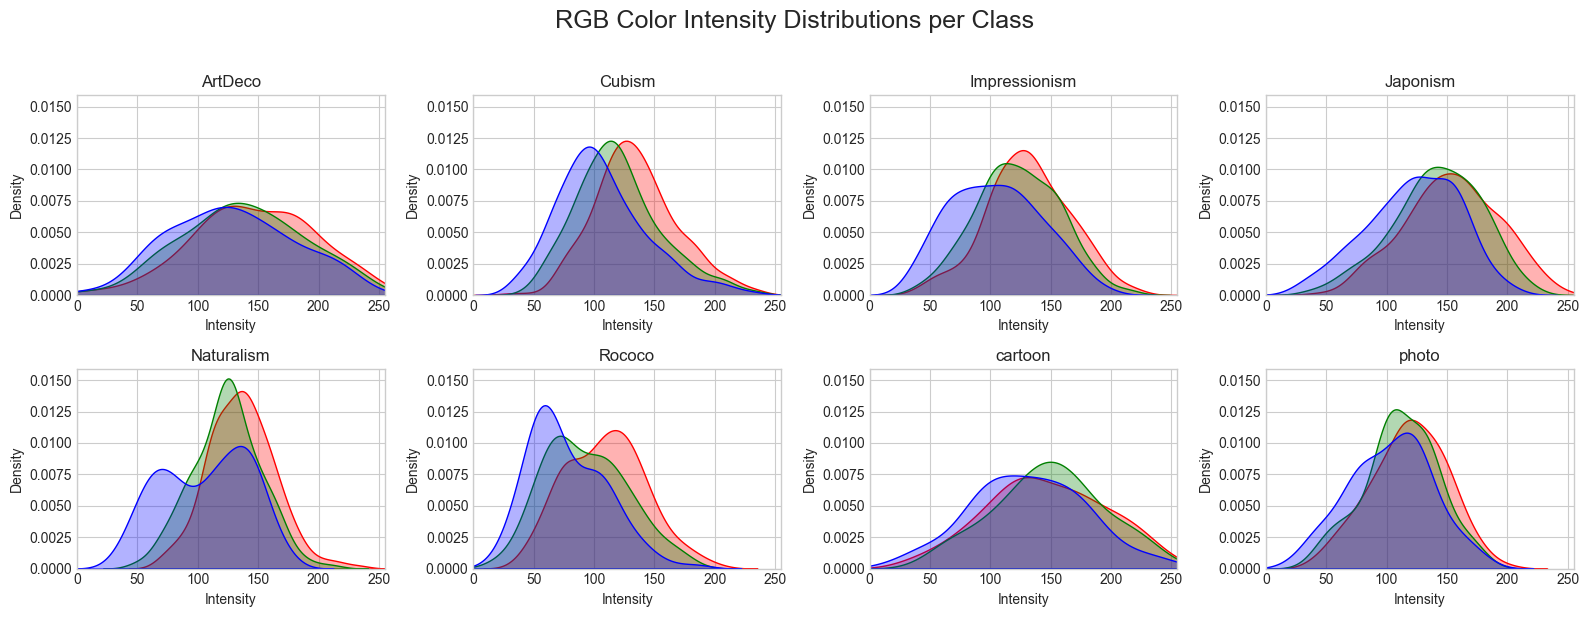

In [11]:
classes = sorted(image_properties_df['class'].unique())

# Create grid
n = len(classes)
cols = 4
rows = -(-n // cols)  # ceil division
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten()

# Track max density for y-axis normalization
max_density = 0

for i, cls in enumerate(classes):
    ax = axes[i]
    df_cls = image_properties_df[image_properties_df['class'] == cls]

    # Plot and store max y for scaling
    r = sns.kdeplot(df_cls['R'], color='red', label='R', fill=True, alpha=0.3, ax=ax)
    g = sns.kdeplot(df_cls['G'], color='green', label='G', fill=True, alpha=0.3, ax=ax)
    b = sns.kdeplot(df_cls['B'], color='blue', label='B', fill=True, alpha=0.3, ax=ax)

    ax.set_title(cls, fontsize=12)
    ax.set_xlim(0, 255)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Density')

    # Track global max y-limit
    max_density = max(max_density, ax.get_ylim()[1])

# Apply consistent y-limits to all plots
for ax in axes[:len(classes)]:
    ax.set_ylim(0, max_density)

# Remove empty subplots if any
for j in range(len(classes), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('RGB Color Intensity Distributions per Class', fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

The distributions above reveal distinct color intensity patterns across art styles.
While most classes show balanced RGB curves, certain styles emphasize specific color channels. For example, Japonism shows a noticeable shift toward higher red channel intensities, suggesting warmer tones.

These findings suggest that color composition varies meaningfully between styles, making RGB channel information a potentially discriminative feature for classification models.
Subsequent statistical tests will quantify whether these observed differences are significant.

### 3.2. Statistical Testing
We perform statistical tests to check whether the differences in color intensities between art styles are significant.

This helps confirm if color is a useful feature for distinguishing the styles.

In [12]:
print("\n=== Levene’s Test for Homogeneity of Variances ===")

for ch in ["R", "G", "B"]:
    groups = [image_properties_df.loc[image_properties_df["class"] == c, ch].values for c in classes]
    stat, p = levene(*groups, center="median")
    
    print(f"\nChannel: {ch}")
    print(f"Levene statistic = {stat:.4f}")
    print(f"p-value          = {p:.6f}")
    print("→ " + (
        "Highly significant (p < 0.001)" if p < 0.001 
        else "Significant (p < 0.05)" if p < 0.05 
        else "Not significant"
    ))



=== Levene’s Test for Homogeneity of Variances ===

Channel: R
Levene statistic = 10.3372
p-value          = 0.000000
→ Highly significant (p < 0.001)

Channel: G
Levene statistic = 7.5023
p-value          = 0.000000
→ Highly significant (p < 0.001)

Channel: B
Levene statistic = 4.5025
p-value          = 0.000056
→ Highly significant (p < 0.001)


Levene’s test shows that class variances differ significantly, meaning a standard ANOVA is not appropriate.

Instead, we use a non-parametric approach — the Kruskal–Wallis H-test — to check whether at least one class differs significantly in color intensity across each channel.

In [13]:
print("\n=== Kruskal–Wallis H-test for Color Intensities ===")
for ch in ["R", "G", "B"]:
    groups = [image_properties_df.loc[image_properties_df["class"] == c, ch].values for c in classes]
    stat, p = kruskal(*groups)
    print(f"\nChannel: {ch}\nH-statistic = {stat:.4f}\np-value     = {p:.6f}")
    print("→ " + ("Highly significant (p < 0.001)" if p < 0.001 else "Significant (p < 0.05)" if p < 0.05 else "Not significant"))


=== Kruskal–Wallis H-test for Color Intensities ===

Channel: R
H-statistic = 138.9779
p-value     = 0.000000
→ Highly significant (p < 0.001)

Channel: G
H-statistic = 172.5756
p-value     = 0.000000
→ Highly significant (p < 0.001)

Channel: B
H-statistic = 133.1101
p-value     = 0.000000
→ Highly significant (p < 0.001)


For all channels, the Kruskal–Wallis test confirms statistically significant differences across classes.
Since the null hypothesis (that all classes share the same color distribution) is rejected, we can conclude that at least one class differs from the others.

To identify which specific classes differ in color intensity, we next perform pairwise Mann–Whitney U tests.

In [14]:
def mannwhitney_pmatrix(df, channel):
    classes = sorted(df['class'].unique())
    mat = pd.DataFrame(np.nan, index=classes, columns=classes)  # NaN by default

    pairs = list(combinations(classes, 2))
    pvals = []

    # Run all pairwise tests
    for a, b in pairs:
        xa = df.loc[df['class'] == a, channel].values
        xb = df.loc[df['class'] == b, channel].values
        _, p = mannwhitneyu(xa, xb, alternative='two-sided')
        pvals.append(p)

    # Holm correction
    p_adj = multipletests(pvals, method='holm')[1]

    # Fill matrix symmetrically
    for (a, b), p in zip(pairs, p_adj):
        mat.loc[a, b] = p
        mat.loc[b, a] = p

    return mat.round(4)

# Generate p-value matrices
p_R = mannwhitney_pmatrix(image_properties_df, 'R')
p_G = mannwhitney_pmatrix(image_properties_df, 'G')
p_B = mannwhitney_pmatrix(image_properties_df, 'B')

# Display each
print("\n")

print("\n=== Pairwise Mann–Whitney p-values (R channel) ===")
display(p_R)
print("\n")

print("\n=== Pairwise Mann–Whitney p-values (G channel) ===")
display(p_G)
print("\n")

print("\n=== Pairwise Mann–Whitney p-values (B channel) ===")
display(p_B)




=== Pairwise Mann–Whitney p-values (R channel) ===


,ArtDeco,Cubism,Impressionism,Japonism,Naturalism,Rococo,cartoon,photo
ArtDeco,NaN,0.3127,0.1525,1.0,0.5595,0.0000,1.0000,0.0004
Cubism,0.3127,NaN,1.0000,0.0,1.0000,0.0000,0.3127,0.0004
Impressionism,0.1525,1.0000,NaN,0.0,0.6327,0.0000,0.1583,0.0130
Japonism,1.0000,0.0000,0.0000,NaN,0.0000,0.0000,1.0000,0.0000
Naturalism,0.5595,1.0000,0.6327,0.0,NaN,0.0000,0.6327,0.0000
Rococo,0.0000,0.0000,0.0000,0.0,0.0000,NaN,0.0000,0.2102
cartoon,1.0000,0.3127,0.1583,1.0,0.6327,0.0000,NaN,0.0004
photo,0.0004,0.0004,0.0130,0.0,0.0000,0.2102,0.0004,NaN





=== Pairwise Mann–Whitney p-values (G channel) ===


,ArtDeco,Cubism,Impressionism,Japonism,Naturalism,Rococo,cartoon,photo
ArtDeco,NaN,0.0240,0.1708,0.911,0.1942,0.0000,0.8220,0.0019
Cubism,0.0240,NaN,0.7223,0.000,0.1708,0.0000,0.0000,0.6271
Impressionism,0.1708,0.7223,NaN,0.000,0.9110,0.0000,0.0001,0.0527
Japonism,0.9110,0.0000,0.0000,NaN,0.0000,0.0000,0.9110,0.0000
Naturalism,0.1942,0.1708,0.9110,0.000,NaN,0.0000,0.0001,0.0074
Rococo,0.0000,0.0000,0.0000,0.000,0.0000,NaN,0.0000,0.0001
cartoon,0.8220,0.0000,0.0001,0.911,0.0001,0.0000,NaN,0.0000
photo,0.0019,0.6271,0.0527,0.000,0.0074,0.0001,0.0000,NaN





=== Pairwise Mann–Whitney p-values (B channel) ===


,ArtDeco,Cubism,Impressionism,Japonism,Naturalism,Rococo,cartoon,photo
ArtDeco,NaN,0.0061,0.0064,1.0000,0.0198,0.0,1.0000,0.0082
Cubism,0.0061,NaN,1.0000,0.0000,1.0000,0.0,0.0001,1.0000
Impressionism,0.0064,1.0000,NaN,0.0000,1.0000,0.0,0.0002,1.0000
Japonism,1.0000,0.0000,0.0000,NaN,0.0005,0.0,1.0000,0.0001
Naturalism,0.0198,1.0000,1.0000,0.0005,NaN,0.0,0.0008,1.0000
Rococo,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000
cartoon,1.0000,0.0001,0.0002,1.0000,0.0008,0.0,NaN,0.0002
photo,0.0082,1.0000,1.0000,0.0001,1.0000,0.0,0.0002,NaN


The pairwise Mann–Whitney U tests show that many class pairs differ significantly in their mean color intensities, especially for the Rococo, Japonism, and photo classes.

These styles consistently have p-values below 0.001 across multiple channels, confirming that their color distributions are distinct.

Overall, the results indicate that color intensity varies meaningfully between several art styles, supporting its use as a discriminative feature in classification.

# Conclusion

The EDA provided several key insights into the dataset’s structure and characteristics, directly guiding the preprocessing and modeling strategy:

1. **Class Imbalance:** The dataset is notably imbalanced. The majority class (Cubism) contains more than five times the number of images as the least represented class (ArtDeco).  This means that *Accuracy* alone is not a sufficient metric. We will need to consider more robust one further.

2. **Image Dimensions and Resizing**: Most images exceed the planned 128×128 training resolution, meaning preprocessing will primarily involve downscaling. This is beneficial since downscaling preserves image quality, while upscaling could introduce artifacts or blur.

3. **Distinct Color Profiles Observed:** Several art styles exhibit distinct color intensity patterns, and statistical tests confirm that these differences are significant. This indicates that color is an important discriminative feature for the classification task. Consequently, color-based augmentations should be applied conservatively to preserve these stylistic differences and avoid distorting class-specific traits.